In [62]:
%plot inline

In [63]:
clear variables; close all; clc;

## Set-up

In [64]:
% Discretization parameters
nx = 81;
ny = 81;
dt = 0.025;
dx = 1/(nx-1);
dy = 1/(ny-1);

% Time interval
t_0 = 0;
tf = 0.25;

% Problem parameters
D = 0.05;
kindergarten = [0.5, 0.5];
W = 1;
theta = pi/2;
a1 = 2;
a2 = 1;
s1 = 100;
s2 = 150;

% Set up arrays for later
x = 0:dx:1;
y = 0:dy:1;
t = 0:dt:tf;
nt = length(t);

## Create u

In [65]:
% the first dimension of u is the flattened spatial dimension,
% and the second dimension is time
u = zeros(ny*nx, nt);

boundaries = [1:ny 1:ny:ny*nx ny:ny:ny*nx nx*(ny-1)+1:nx*ny];
% (above) might be less confusing to use the G function for this...

%% Initial condition
u0 = a1*exp(-s1*bsxfun(@plus, (x-0.25).^2, (y'-0.25).^2)) + ...
     a2*exp(-s2*bsxfun(@plus, (x-0.65).^2, (y'-0.4).^2));
u(:,1) = u0(:); % flatten
u(boundaries,1) = 0; % set initial condition at boundaries to 0

## Initial plot

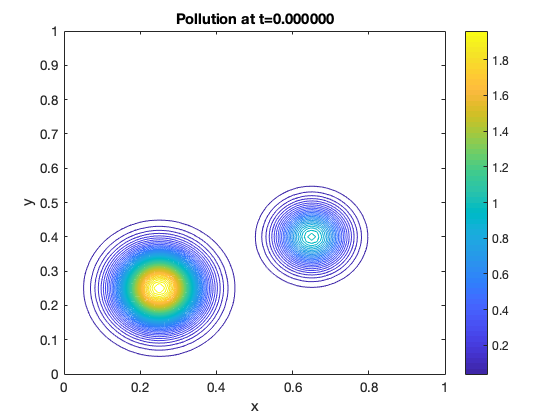

In [66]:
uplot = reshape(u, [ny, nx, nt]);

num_contours = 50;

figure;
contour(x, y, uplot(:,:,1), num_contours);
colorbar;
title(sprintf('Pollution at t=%f', 0));
xlabel('x');
ylabel('y');

## Creating the 'A' Matrix

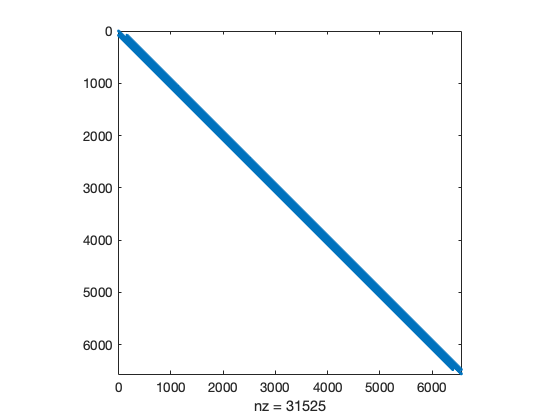

In [67]:
A = createA(D, W, theta, nx, ny, dx, dy, dt);
spy(A) % generate sparsity visualization

The plot above makes it very hard to see the actual pattern, so we can zoom in to a region near the middle:

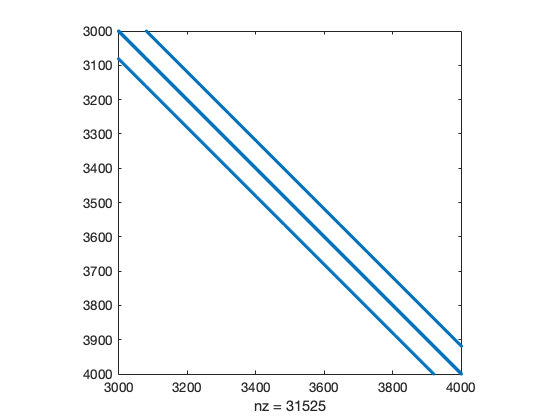

In [68]:
spy(A)
xlim([3000 4000])
ylim([3000 4000])

This is alright, but we can do better...

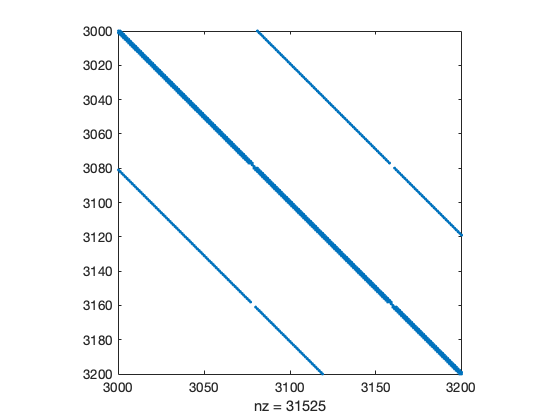

In [69]:
spy(A)
xlim([3000 3200])
ylim([3000 3200])

We can now start to see the true structure of the matrix entries. Let's zoom in one more time.

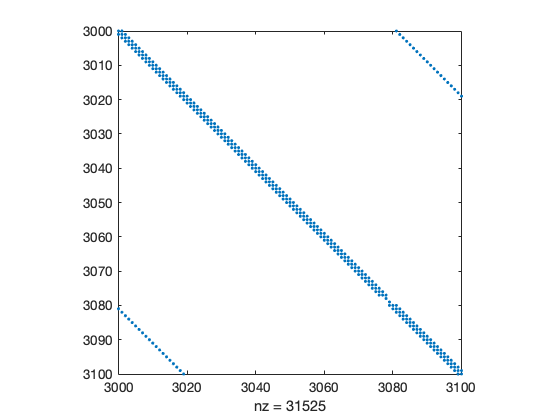

In [70]:
spy(A)
xlim([3000 3100])
ylim([3000 3100])

This final figure lets us see the precise layout of the nonzero entries, which closely reflects the mathematical definitions we had in the previous part of the assignment. In particular, we can see the (roughly) 5 nonzero entries per row that correspond to the 5 evaluations of the pollution function used to compute the discretized derivative at each point. The three entries in the center ribbon correspond to the center and vertically-adjacent points (since we use column-major order) and the two entries bordering these (~81 entries away) are the horizontal neighbours. The gaps in the center line indicate identity rows, which correspond to points on the border of our grid.

## Solving the PDE Numerically
For the purposes of reusability, let us define a function that updates our u vectors, using a given A and number of time steps

In [71]:
%%file beuler.m
function u = beuler(A, nt, u)
    for i = 2:nt
            u(:,i) = A \ u(:, i-1);
    end
end

Created file '/Users/rlindsay/Documents/School/18W2/CPSC 303/5b/beuler.m'.


and a function to plot the pollution for a given time step:

In [72]:
%%file makeplot.m
function out = makeplot(t, dt, ny, nx, nt, x, y, u)
    uplot = reshape(u, [ny, nx, nt]);
    num_contours = 50;
    figure;
    contour(x, y, uplot(:,:,t), num_contours);
    colorbar;
    title(sprintf('Pollution at t=%f', (t - 1)*dt));
    xlabel('x');
    ylabel('y');
    out = 1;
end

Created file '/Users/rlindsay/Documents/School/18W2/CPSC 303/5b/makeplot.m'.


Next, we'll run the backward Euler integration and plot at three time steps, t = 0, 0.125, 0.25. Note: this code takes about 30 seconds to run, which is accurately described as "painfully slow"

In [73]:
% tic
% u = beuler(A, nt, u);
% update_time = toc
% makeplot(11, dt, ny, nx, nt, x, y, u);
% makeplot(6, dt, ny, nx, nt, x, y, u);
% makeplot(1, dt, ny, nx, nt, x, y, u);   % had to invert these to get plots in right order

update_time = 42;  % temporary value so we don't have to run the slow code -REMOVE BEFORE SUBMITTING!

Gotta go fast

In [74]:
tic
beuler(sparse(A), nt, u);  % perform the same integration using the sparse version of A
update_time_sparse = toc


update_time_sparse =

    0.3583



In [75]:
speedup = update_time / update_time_sparse


speedup =

  117.2171



## Solving Speedily (part h)
We can now carry out the same integration as above but with a much smaller step size, and in a reasonable amount of time. We do this with dt=0.005, and plot the beginning, middle, and end time steps (as before).


dt =

    0.0050



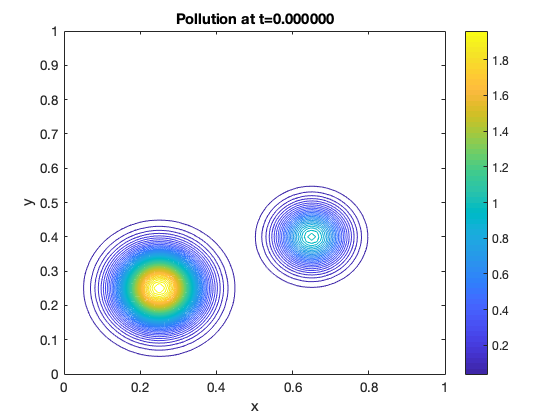

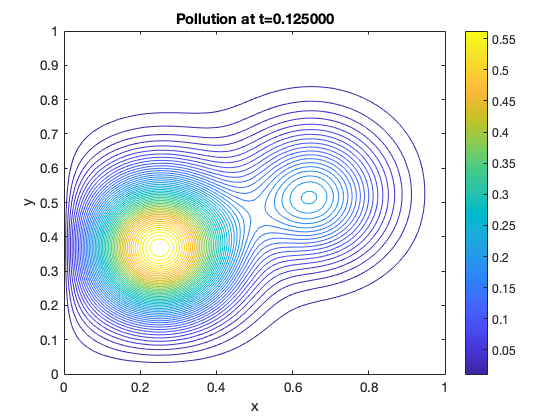

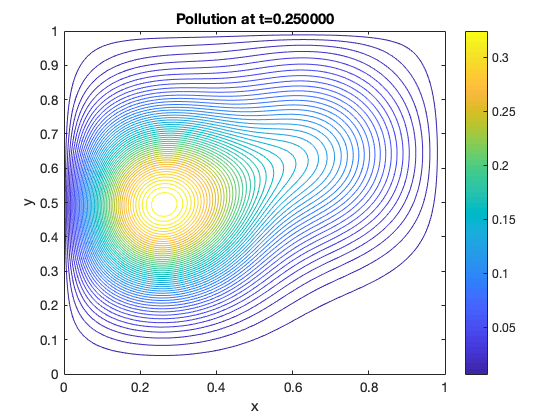

In [76]:
dt = 0.005  % set t step-size to new value
t = 0:dt:tf;   % update the parameters that depend on dt
nt = length(t);

A = createA(D, W, theta, nx, ny, dx, dy, dt);  % create the new matrix

u = beuler(sparse(A), nt, u);
makeplot(51, dt, ny, nx, nt, x, y, u);
makeplot(26, dt, ny, nx, nt, x, y, u);
makeplot(1, dt, ny, nx, nt, x, y, u);

We see that we have produced seemingly equivalent (although likely more accurate) plots in a fraction of the time.